# kuzushiji-recognition

### importing libraries

In [1]:
%matplotlib inline

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import ImageFont, ImageDraw, Image
import pandas as pd
import numpy as np
import cv2
import os

### importing dataset

In [2]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("sample_submission.csv")
df_decode = pd.read_csv("unicode_translation.csv")
profile = ProfileReport(df, title="Pandas Profiling Report")
X = df.iloc[:,:].values
df.head(5)

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [3]:
df_test.head(5)

,image_id,labels,Useage
0,test_001c37e2,U+003F 1 1 U+FF2F 2 2,Private
1,test_003aa33a,U+003F 1 1 U+FF2F 2 2,Public
2,test_00665e33,U+003F 1 1 U+FF2F 2 2,Private
3,test_0082d2cd,U+003F 1 1 U+FF2F 2 2,Private
4,test_0086f578,U+003F 1 1 U+FF2F 2 2,Private


In [4]:
df_decode.head(5)

,Unicode,char
0,U+0031,1
1,U+0032,2
2,U+0034,4
3,U+0036,6
4,U+0039,9


### visualizing a random label

In [5]:
lab = df["labels"][0]
print(lab)

U+306F 1231 3465 133 53 U+304C 275 1652 84 69 U+3044 1495 1218 143 69 U+3051 220 3331 53 91 U+306B 911 1452 61 92 U+306B 927 3445 71 92 U+306E 904 2879 95 92 U+5DE5 1168 1396 187 95 U+3053 289 3166 69 97 U+4E09 897 3034 121 107 U+306E 547 1912 141 108 U+3084 1489 2675 151 109 U+3068 1561 2979 55 116 U+5DF1 1513 2500 127 117 U+3082 1213 1523 72 119 U+3055 1219 3266 95 124 U+306E 259 2230 68 125 U+306E 1184 2423 169 125 U+4E16 849 2236 163 127 U+7D30 1144 1212 200 128 U+305D 316 3287 57 133 U+4EBA 217 2044 183 135 U+3051 277 2974 112 137 U+308C 201 3423 181 137 U+3060 243 2830 159 143 U+5F37 1479 2034 163 145 U+306E 1497 1567 123 152 U+305F 1164 952 145 153 U+3066 552 1199 97 155 U+4FF3 537 2095 176 155 U+6839 203 1439 184 156 U+304B 1188 2606 156 157 U+8AE7 549 2328 156 159 U+308C 1495 2784 168 159 U+5B50 891 1255 100 164 U+3092 584 2546 117 164 U+53CA 849 1588 151 164 U+8005 1192 2198 133 169 U+305A 889 1763 103 171 U+907F 513 945 181 171 U+6B63 539 1439 136 172 U+6587 192 2382 216 173

In [6]:
def break_down_label(y):
    my_label = df["labels"][y].split()
    letters, x_coord, y_coord, width, heights = [], [], [], [], []
    for i in range(0,len(my_label),5):
        try:
            letters.append(my_label[i  ] + " ")
            x_coord.append(my_label[i+1] + " ")
            y_coord.append(my_label[i+2] + " ")
            width.append(my_label[i+3] + " ")
            heights.append(my_label[i+4] + " ")
        except Exception as e :
            print(e)
            #pass
    return letters, x_coord, y_coord, width, heights

def draw_rect_img(img, y, thickness = 3, color = (255,0,0)):
    letters, x_coord, y_coord, width, heights = break_down_label(y)
    for i in range(len(width)):
        start_point = (int(x_coord[i]), int(y_coord[i]))
        end_point   = (int(width[i]) + int(x_coord[i]), int(heights[i]) + int(y_coord[i]))
        img = cv2.rectangle(img ,start_point, end_point , color, thickness)
    return img

def draw_labels_img(img, y, thickness = 3, color = (155,0,155)):
    fontpath = "./simsun.ttc"
    font = ImageFont.truetype(fontpath, 52)
    letters, x_coord, y_coord, width, heights = break_down_label(y)
    for i in range(len(width)):
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((int(x_coord[i])-100, int(y_coord[i])),  transform(letters[i], df_decode), font = font, fill = color)#transform(letters[i], df_decode)
        img = np.array(img_pil)
        img = img[:, :, ::-1].copy() 
    return img

def update_counter(counter, i, df_decode):
    X_decode = df_decode.iloc[:,:].values
    letters, _, _, _, _ = break_down_label(i)
    for j in range(len(letters)):
        index = np.where(X_decode[:,0] == letters[j].strip())
        counter[index] += 1
    return counter
        
    #my_label = df["labels"][i].split()
    return counter

def transform(letter,df_decode):
    try:
        letter = letter.strip()
        X_decode = df_decode.iloc[:,:].values
        #unicodes = X_decode[:,0].tolist()
        #index = unicodes.index(letter)
        index = np.where(X_decode[:,0] == letter)
        decoded_letter = X_decode[index,1][0][0]
    except:
        decoded_letter = "ERROR"
    return decoded_letter

letters, x_coord, y_coord, width, heights = break_down_label(0)

for i in range(10): #len(letters)
    print("Letter (Unicode): "+letters[i] + "Which is : " + transform(letters[i], df_decode))
    print("Coordinates are : ("+x_coord[i] + ", "+y_coord[i] + ", "+width[i] + ", "+heights[i] + ")\n\n " )
    

Letter (Unicode): U+306F Which is : は
Coordinates are : (1231 , 3465 , 133 , 53 )

 
Letter (Unicode): U+304C Which is : が
Coordinates are : (275 , 1652 , 84 , 69 )

 
Letter (Unicode): U+3044 Which is : い
Coordinates are : (1495 , 1218 , 143 , 69 )

 
Letter (Unicode): U+3051 Which is : け
Coordinates are : (220 , 3331 , 53 , 91 )

 
Letter (Unicode): U+306B Which is : に
Coordinates are : (911 , 1452 , 61 , 92 )

 
Letter (Unicode): U+306B Which is : に
Coordinates are : (927 , 3445 , 71 , 92 )

 
Letter (Unicode): U+306E Which is : の
Coordinates are : (904 , 2879 , 95 , 92 )

 
Letter (Unicode): U+5DE5 Which is : 工
Coordinates are : (1168 , 1396 , 187 , 95 )

 
Letter (Unicode): U+3053 Which is : こ
Coordinates are : (289 , 3166 , 69 , 97 )

 
Letter (Unicode): U+4E09 Which is : 三
Coordinates are : (897 , 3034 , 121 , 107 )

 


### visualizing few examples

In [7]:
def convert_pic(sample_id):    
    image_file = Image.open("train_images/" + sample_id + ".jpg") # open colour image
    image_file = prepare_img(random_img)
    #image_file = image_file.convert('1') # convert image to black and white
    image_file.save("new_train/"+sample_id+".jpg")
    
def prepare_image(df, num_imgs,proc = False):
    imgs, labels = [], []
    for i in range(num_imgs):
        index = i*10
        sample_id = df["image_id"][index]
        if proc == False:
            random_img_path ="train_images/" + sample_id + ".jpg"
        else:
            random_img_path ="train_images/" + sample_id + ".jpg"
        #reading the img
        random_img = cv2.imread(random_img_path)
        if proc:
            random_img = prepare_img(random_img)
        else:
            #converting the img to an RGB colored img
            random_img = cv2.cvtColor(random_img, cv2.COLOR_BGR2RGB)
        imgs.append(random_img)
        labels.append(index)
    return imgs, labels

def unpack(*my_list):
    for item in my_list:
        return item


def prepare_img(Image): 
    im_color = Image
    im_gray = cv2.cvtColor(im_color, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(im_gray, thresh=150, maxval=255, type=cv2.THRESH_BINARY)
    im_thresh_gray = cv2.bitwise_and(im_gray, mask)
    mask3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # 3 channel mask
    return mask3 #im_thresh_gray

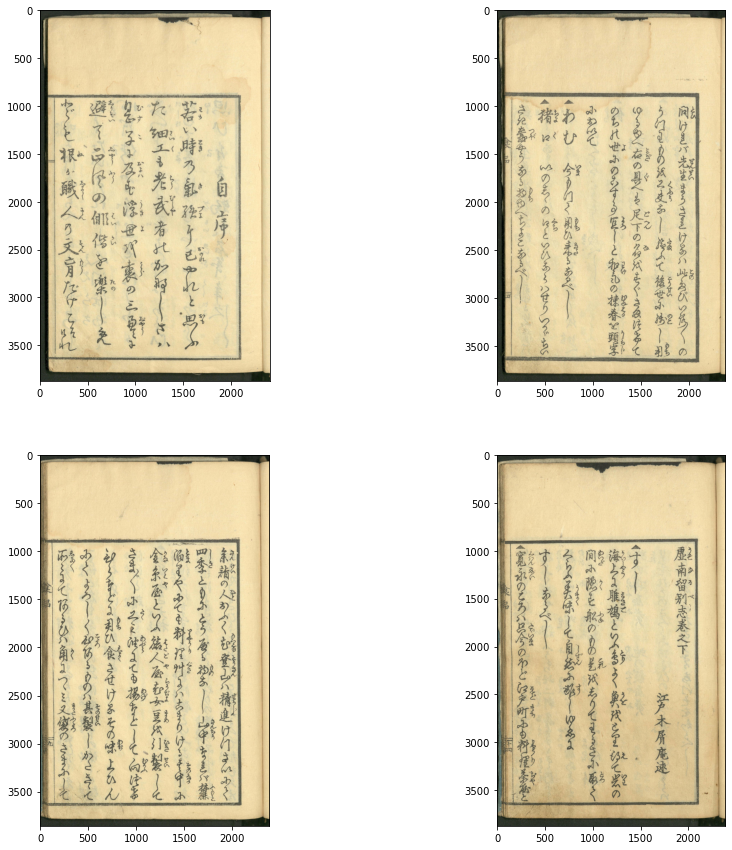

In [8]:
fig = plt.figure(figsize=(15,15))
imgs, labels = prepare_image(df, 4)
img_1, img_2, img_3, img_4 = unpack(imgs)

# Plot imgs
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_1)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_2)
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img_3)
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_4)

# Data Preprocessing

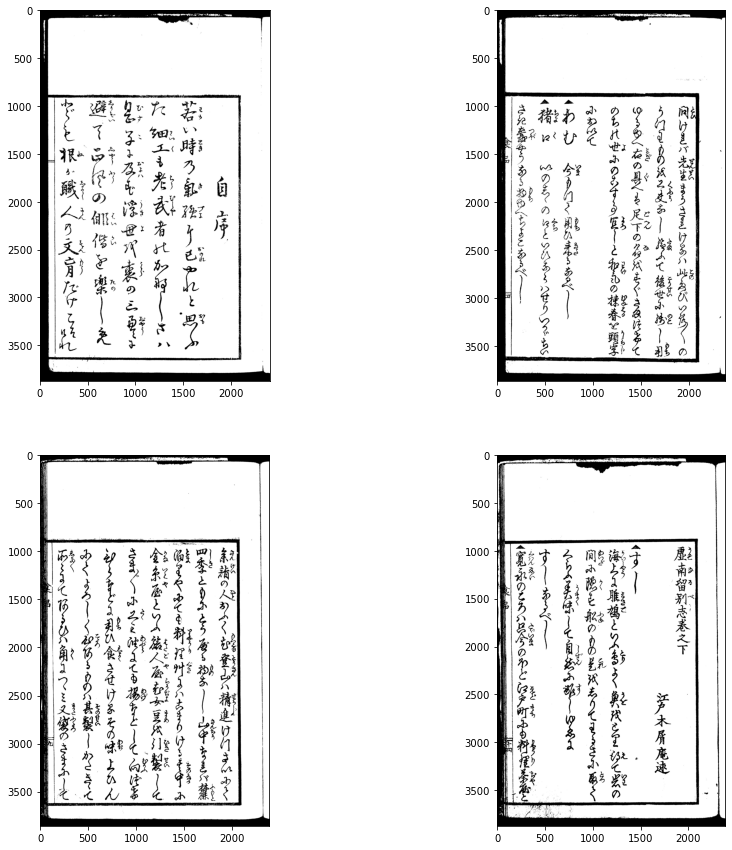

In [9]:
fig = plt.figure(figsize=(15,15))
imgs, labels = prepare_image(df, 4, True)
img_1, img_2, img_3, img_4 = unpack(imgs)

# Plot imgs
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_1)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_2)
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img_3)
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(img_4)

### Preparing the train set

In [9]:
for i in tqdm(range(len(df["image_id"]))):
    img_path ="train_images/" + df["image_id"][i] + ".jpg"
    img = cv2.imread(img_path)
    img = prepare_img(img)
    cv2.imwrite("train_images_bw/"+df["image_id"][i] + ".jpg", img) 


commented out because it needs to be excuted only once

  0%|                                                                | 0/3605 [00:00<?, ?it/s]

3605


100%|█████████████████████████████████████████████████████| 3605/3605 [41:51<00:00,  1.44it/s]


### Preparing the test set

In [ ]:
for i in tqdm(range(len(df_test["image_id"]))):
    img_path ="test_images/" + df_test["image_id"][i] + ".jpg"
    img = cv2.imread(img_path)
    img = prepare_img(img)
    cv2.imwrite("test_images_bw/"+df_test["image_id"][i] + ".jpg", img) 

## Get individual caracteres and labeling them

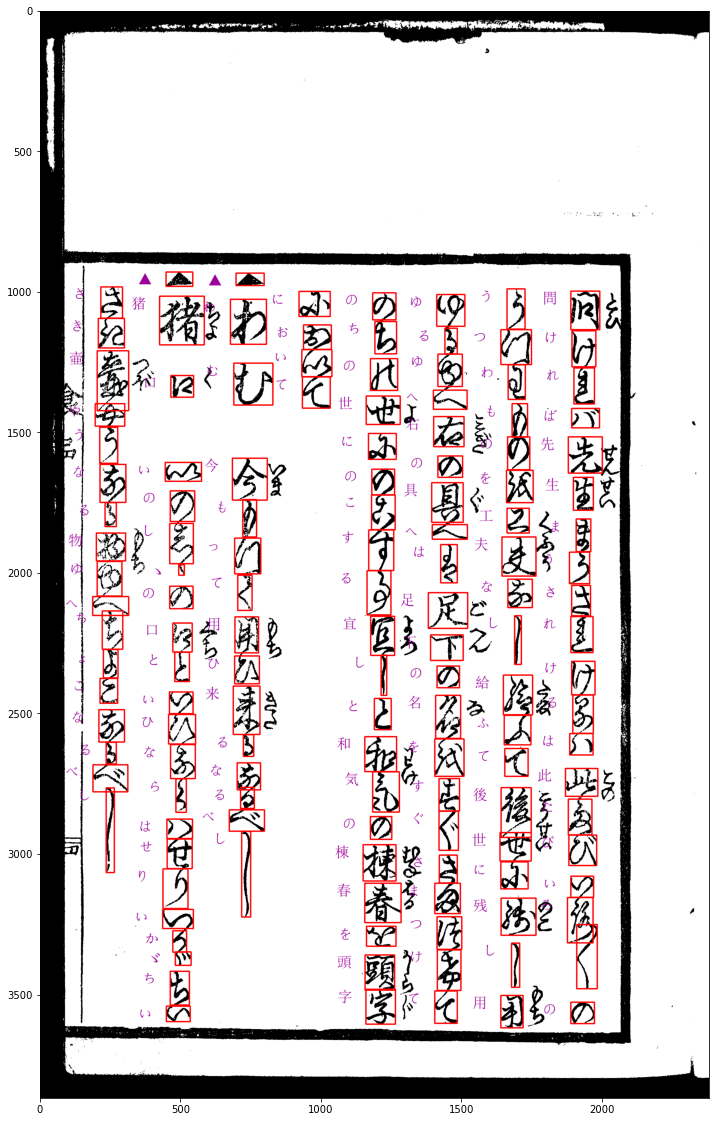

In [10]:
fig = plt.figure(figsize=(20,20))
imgs, labels = prepare_image(df, 2, True)
img_1, img_2 = unpack(imgs)
y_1, y_2 = unpack(labels)
img_2 = draw_rect_img(img_2, y_2, 3)
img_2 = draw_labels_img(img_2, y_2, 3)
plt.imshow(img_2)

## Getting word count and analyzing data destribution

In [18]:
counter = np.zeros((df_decode.shape[0],), dtype=int)
for i in range(len(df["image_id"])):
    counter = update_counter(counter, i, df_decode)
    if i%400 == 0:
        print((i/40)+9, " %")
print("Done")

9.0  %
19.0  %
29.0  %
39.0  %
49.0  %
59.0  %
69.0  %
79.0  %
89.0  %
99.0  %
Done


In [12]:
# to convert lists to dictionary 
X_decode = df_decode.iloc[:,0].values
counted_elements = {X_decode[i]: counter[i] for i in range(len(counter))} 
print(len(counted_elements))

4781


In [19]:
print("The number of caracters is : ", counter.sum())
# Number of characters that showed in all pictures:
print("The number of elements that showed up 0 time", np.count_nonzero(counter==0))
print("The number of elements that showed up 1 time", np.count_nonzero(counter==1))
print("The number of elements that showed up less than 10 times", np.count_nonzero(counter<10))
print("The number of elements that showed up less than 50 times", np.count_nonzero(counter<50))
print("\nThe number of elements that showed up MORE than 100 times", np.count_nonzero(counter>100))

The number of caracters is :  683442
The number of elements that showed up 0 time 575
The number of elements that showed up 1 time 788
The number of elements that showed up less than 10 times 2753
The number of elements that showed up less than 50 times 3795

The number of elements that showed up MORE than 100 times 621


Text(0.5, 0.98, 'Letters Count')

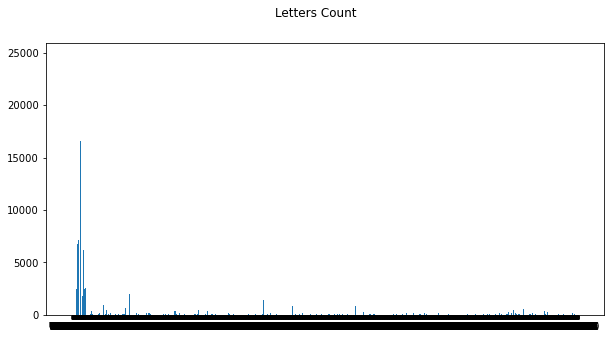

In [14]:
fig = plt.figure(figsize=(10,5))
plt.bar(X_decode, counter)
fig.suptitle('Letters Count')

Text(0.5, 0.98, 'Letters Count')

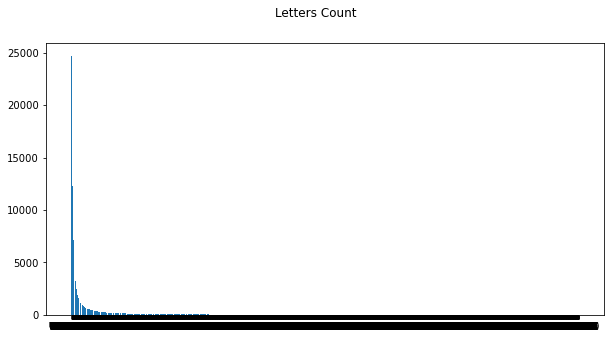

In [20]:
# Sorting the counted elements in descending order
counter[::-1].sort()
fig = plt.figure(figsize=(10,5))
plt.bar(X_decode, counter)
fig.suptitle('Letters Count')

Text(0.5, 0.98, 'Letters Count')

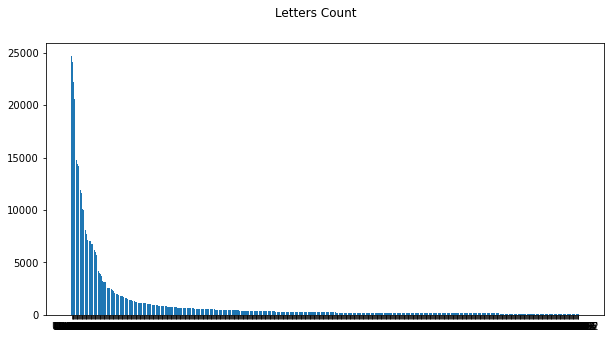

In [22]:
# Plotting only the elements that showed up more than 100 times:
fig = plt.figure(figsize=(10,5))
plt.bar(X_decode[:621], counter[:621])
fig.suptitle('Letters Count')

In [ ]:
# Therefore we don't have equal samples to train the model and 575 label did not appear at all in the training data
# The graph follows the ZIPF shape,

In [ ]:
""" Next steps:
0/ Preprocessing: create a function that transform a digit and put it into the center and adds zeros so we can have degits with the same shape
1. Train a model that detects a digit coord so we can use our function to transform it into it's own img
2. Train a classification model that will train on single letters or a seq to seq model maybe

"""